In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 15:02:25] [setup] RAM Tracking...
[codecarbon INFO @ 15:02:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:02:25] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:02:25] [setup] CPU Tracking...
[codecarbon WARNING @ 15:02:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:02:28] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 15:02:28] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 15:02:28] >>> Tracker's metadata:
[codecarbon INFO @ 15:02:28]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 15:02:28]   Python version: 3.11.3
[codecarbon INFO @ 15:02:28]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:02:28]   Available RAM : 256.000 GB
[codecarbon INFO @ 15:02:28]   CPU count: 24
[codecarbon INFO @ 15:02:28]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [3]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


y987bcsjw88r


In [8]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [13]:
!ls ../../csv

highest_vs_rest_balanced_jira.csv
jira_highest_vs_rest_clean_Jira_balanced.csv
jira_highest_vs_rest_clean_MongoDB_balanced.csv
jira_highest_vs_rest_clean_Qt_balanced.csv


In [14]:
project_name  = "Qt"
file_name = f"../../csv/jira_highest_vs_rest_clean_{project_name}_balanced.csv"

In [15]:
import pandas as pd
fine_tuning_df = pd.read_csv(file_name)
fine_tuning_df

,text_clean,label
0,using this example run via qmlscene code impor...,0
1,if i happen to get two modal dialogs open at t...,1
2,the attached screenshot shows that the zapfino...,0
3,hello i have some issues with mysqlopenssl lib...,0
4,we have a few updates to webkit that the webki...,1
...,...,...
3877,this was actually with the packageto reproduce...,1
3878,a fairly sure way to cause this crash is to in...,1
3879,it seems every example in the dev branch curre...,1
3880,the style seems to have a few rough edgesthere...,0


In [16]:
fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,using this example run via qmlscene code impor...,0
1,if i happen to get two modal dialogs open at t...,1
2,the attached screenshot shows that the zapfino...,0
3,hello i have some issues with mysqlopenssl lib...,0
4,we have a few updates to webkit that the webki...,1
...,...,...
3877,this was actually with the packageto reproduce...,1
3878,a fairly sure way to cause this crash is to in...,1
3879,it seems every example in the dev branch curre...,1
3880,the style seems to have a few rough edgesthere...,0


In [17]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [18]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [19]:
fine_tune_train_df

,text,label
3432,mingw version of gcc bundled with qt has a ver...,1
1018,pressing a button inside a mousearea and then ...,0
1941,due to a malfunctioning script all the fastfor...,1
3614,introduced by change,1
1200,codejava import qtquick text textformat textpl...,0
...,...,...
1171,building existing project eg any example in wi...,1
1295,noformat fail tstcontrolstestopenduringexittra...,0
361,creation of work items failed most recent call...,1
135,there is no way to propagate errors from an im...,0


In [20]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [21]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
37394,1,building existing project eg any example in wi...
37395,0,noformat fail tstcontrolstestopenduringexittra...
37396,1,creation of work items failed most recent call...
37397,0,there is no way to propagate errors from an im...


In [22]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [23]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6247
       0        6220
1      0        6258
       1        6208
2      1        6251
       0        6215
Name: count, dtype: int64

In [24]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,1
1,0,overwriting bookmark folders when syncing devi...,0
2,0,no results if country is specified in the quer...,2
3,0,prepopulate subject of message when clicking r...,2
4,0,timeout on wiki listoffeaturedimages does not ...,1
...,...,...,...
37394,1,building existing project eg any example in wi...,2
37395,0,noformat fail tstcontrolstestopenduringexittra...,0
37396,1,creation of work items failed most recent call...,0
37397,0,there is no way to propagate errors from an im...,0


In [25]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [26]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [27]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [28]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [29]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [30]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [32]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [33]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [34]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [35]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [36]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 780/780 [02:07<00:00,  6.10it/s, Epoch=1, LR=8.86e-6, Valid_Loss=0.516]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7735    0.6814    0.7245      6220
          HP     0.7164    0.8013    0.7565      6247

    accuracy                         0.7415     12467
   macro avg     0.7449    0.7413    0.7405     12467
weighted avg     0.7449    0.7415    0.7405     12467

Accuracy = 0.7415
F1_score = 0.7565
Validation Loss Improved (inf ---> 0.5155074404495954)
Model Saved



100%|██████████| 780/780 [02:07<00:00,  6.10it/s, Epoch=2, LR=6.01e-6, Valid_Loss=0.483]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7147    0.8690    0.7843      6220
          HP     0.8338    0.6546    0.7334      6247

    accuracy                         0.7615     12467
   macro avg     0.7742    0.7618    0.7588     12467
weighted avg     0.7744    0.7615    0.7588     12467

Accuracy = 0.7615
F1_score = 0.7334
Validation Loss Improved (0.5155074404495954 ---> 0.48281456368616094)
Model Saved



100%|██████████| 780/780 [02:08<00:00,  6.09it/s, Epoch=3, LR=2.9e-6, Valid_Loss=0.501]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7632    0.7976    0.7800      6220
          HP     0.7890    0.7536    0.7709      6247

    accuracy                         0.7756     12467
   macro avg     0.7761    0.7756    0.7755     12467
weighted avg     0.7761    0.7756    0.7755     12467

Accuracy = 0.7756
F1_score = 0.7709

Training complete in 0h 48m 42s
Best Loss: 0.4828


Train Loss,█▃▁
Valid Accuracy,▁▅█
Valid F1_score,▅▁█
Valid Loss,█▁▅
Best Loss,0.48281
Train Loss,0.40589
Valid Accuracy,0.7756
Valid F1_score,0.7709
Valid Loss,0.50107



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 780/780 [02:07<00:00,  6.11it/s, Epoch=1, LR=8.86e-6, Valid_Loss=0.529]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.8202    0.5818    0.6808      6258
          HP     0.6740    0.8715    0.7601      6208

    accuracy                         0.7261     12466
   macro avg     0.7471    0.7266    0.7204     12466
weighted avg     0.7474    0.7261    0.7203     12466

Accuracy = 0.7261
F1_score = 0.7601
Validation Loss Improved (inf ---> 0.5290658293854037)
Model Saved



100%|██████████| 780/780 [02:07<00:00,  6.11it/s, Epoch=2, LR=6.01e-6, Valid_Loss=0.479]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7120    0.8872    0.7900      6258
          HP     0.8488    0.6382    0.7286      6208

    accuracy                         0.7632     12466
   macro avg     0.7804    0.7627    0.7593     12466
weighted avg     0.7801    0.7632    0.7594     12466

Accuracy = 0.7632
F1_score = 0.7286
Validation Loss Improved (0.5290658293854037 ---> 0.4792036279694104)
Model Saved



100%|██████████| 780/780 [02:07<00:00,  6.12it/s, Epoch=3, LR=2.9e-6, Valid_Loss=0.461]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7650    0.8161    0.7897      6258
          HP     0.8012    0.7473    0.7733      6208

    accuracy                         0.7818     12466
   macro avg     0.7831    0.7817    0.7815     12466
weighted avg     0.7830    0.7818    0.7815     12466

Accuracy = 0.7818
F1_score = 0.7733
Validation Loss Improved (0.4792036279694104 ---> 0.46139877162468523)
Model Saved

Training complete in 0h 49m 0s
Best Loss: 0.4614


Train Loss,█▃▁
Valid Accuracy,▁▆█
Valid F1_score,▆▁█
Valid Loss,█▃▁
Best Loss,0.4614
Train Loss,0.40629
Valid Accuracy,0.7818
Valid F1_score,0.7733
Valid Loss,0.4614



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 780/780 [02:06<00:00,  6.14it/s, Epoch=1, LR=8.86e-6, Valid_Loss=0.506]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7306    0.7707    0.7501      6215
          HP     0.7589    0.7175    0.7376      6251

    accuracy                         0.7440     12466
   macro avg     0.7448    0.7441    0.7439     12466
weighted avg     0.7448    0.7440    0.7439     12466

Accuracy = 0.744
F1_score = 0.7376
Validation Loss Improved (inf ---> 0.5055044941853964)
Model Saved



100%|██████████| 780/780 [02:06<00:00,  6.15it/s, Epoch=2, LR=6.01e-6, Valid_Loss=0.464]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7782    0.7575    0.7677      6215
          HP     0.7651    0.7853    0.7751      6251

    accuracy                         0.7715     12466
   macro avg     0.7717    0.7714    0.7714     12466
weighted avg     0.7716    0.7715    0.7714     12466

Accuracy = 0.7715
F1_score = 0.7751
Validation Loss Improved (0.5055044941853964 ---> 0.4642308217534739)
Model Saved



100%|██████████| 780/780 [02:06<00:00,  6.14it/s, Epoch=3, LR=2.9e-6, Valid_Loss=0.472]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7195    0.8980    0.7989      6215
          HP     0.8654    0.6519    0.7436      6251

    accuracy                         0.7746     12466
   macro avg     0.7924    0.7749    0.7712     12466
weighted avg     0.7926    0.7746    0.7712     12466

Accuracy = 0.7746
F1_score = 0.7436

Training complete in 0h 48m 55s
Best Loss: 0.4642


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁█▂
Valid Loss,█▁▂
Best Loss,0.46423
Train Loss,0.41543
Valid Accuracy,0.7746
Valid F1_score,0.7436
Valid Loss,0.47239


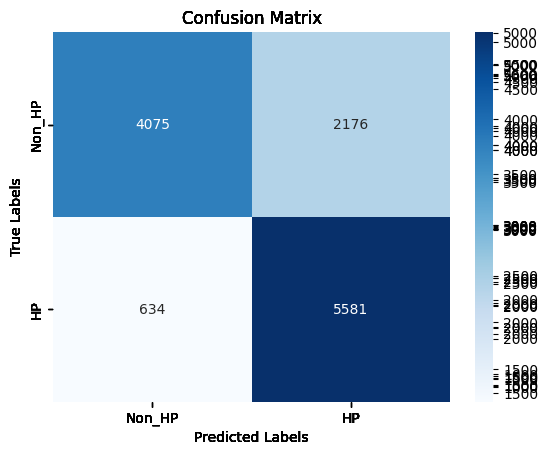

In [37]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [38]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [39]:
test_df = fine_tune_test_df

In [40]:
test_df

,text,label
1151,the documentation for qdatawidgetmapper indica...,0
2586,currently moc supports qnamespace only in top ...,0
1053,in cups my printer is configured to use duplex...,0
3222,component qtqtimageformats fails to build agai...,1
22,update submodules on in code homeqtworkqtqtxml...,1
...,...,...
1130,i have a timeline with objects in it done with...,0
1294,compiling single module with yocto sdk works f...,0
860,the performance of graphicsview on maemo devic...,0
3507,after updating to qt creator half of tests of ...,0


In [41]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [42]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [43]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [44]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [45]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [46]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 170/170 [00:27<00:00,  6.18it/s]


Fold 1


100%|██████████| 170/170 [00:27<00:00,  6.26it/s]


Fold 2


100%|██████████| 170/170 [00:27<00:00,  6.25it/s]


In [47]:
deberta_predictions


[array([[0.54018956, 0.45981044],
        [0.5078179 , 0.49218208],
        [0.74631554, 0.25368446],
        ...,
        [0.8956492 , 0.10435088],
        [0.58427685, 0.41572317],
        [0.53691983, 0.46308014]], dtype=float32),
 array([[0.68628913, 0.31371093],
        [0.33556995, 0.66443   ],
        [0.80948865, 0.19051135],
        ...,
        [0.9077686 , 0.09223145],
        [0.22470482, 0.7752952 ],
        [0.652297  , 0.347703  ]], dtype=float32),
 array([[0.5789673 , 0.42103276],
        [0.52200276, 0.4779972 ],
        [0.70716155, 0.29283842],
        ...,
        [0.83066803, 0.16933204],
        [0.31705096, 0.68294907],
        [0.3240367 , 0.6759633 ]], dtype=float32)]

In [48]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.6018153 , 0.3981847 ],
       [0.4551302 , 0.5448698 ],
       [0.7543219 , 0.24567807],
       ...,
       [0.87802863, 0.12197145],
       [0.3753442 , 0.6246558 ],
       [0.50441784, 0.49558213]], dtype=float32)

In [49]:
len(predictions)

2718

In [50]:
predictions

array([[0.6018153 , 0.3981847 ],
       [0.4551302 , 0.5448698 ],
       [0.7543219 , 0.24567807],
       ...,
       [0.87802863, 0.12197145],
       [0.3753442 , 0.6246558 ],
       [0.50441784, 0.49558213]], dtype=float32)

In [51]:
test_df["prediction_0"] = predictions[:, 0] 

In [52]:
test_df["prediction_1"] = predictions[:, 1] 

In [53]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [54]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1151,the documentation for qdatawidgetmapper indica...,0,0.601815,0.398185,0,0,0
2586,currently moc supports qnamespace only in top ...,0,0.455130,0.544870,0,1,0
1053,in cups my printer is configured to use duplex...,0,0.754322,0.245678,0,0,0
3222,component qtqtimageformats fails to build agai...,1,0.239013,0.760987,1,1,1
22,update submodules on in code homeqtworkqtqtxml...,1,0.134827,0.865173,1,1,1
...,...,...,...,...,...,...,...
1130,i have a timeline with objects in it done with...,0,0.482109,0.517891,0,0,1
1294,compiling single module with yocto sdk works f...,0,0.551924,0.448076,0,0,1
860,the performance of graphicsview on maemo devic...,0,0.878029,0.121971,0,0,0
3507,after updating to qt creator half of tests of ...,0,0.375344,0.624656,0,1,1


In [55]:
len(test_df)

2718

In [56]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [57]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [58]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [59]:
test_df["pred"] = test_df["pred"].astype(int)

In [60]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1151,the documentation for qdatawidgetmapper indica...,0,0.601815,0.398185,0,0,0,prediction_0,0
2586,currently moc supports qnamespace only in top ...,0,0.455130,0.544870,0,1,0,prediction_1,1
1053,in cups my printer is configured to use duplex...,0,0.754322,0.245678,0,0,0,prediction_0,0
3222,component qtqtimageformats fails to build agai...,1,0.239013,0.760987,1,1,1,prediction_1,1
22,update submodules on in code homeqtworkqtqtxml...,1,0.134827,0.865173,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
1130,i have a timeline with objects in it done with...,0,0.482109,0.517891,0,0,1,prediction_1,1
1294,compiling single module with yocto sdk works f...,0,0.551924,0.448076,0,0,1,prediction_0,0
860,the performance of graphicsview on maemo devic...,0,0.878029,0.121971,0,0,0,prediction_0,0
3507,after updating to qt creator half of tests of ...,0,0.375344,0.624656,0,1,1,prediction_1,1


In [61]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[ 935  441]
 [ 234 1108]]


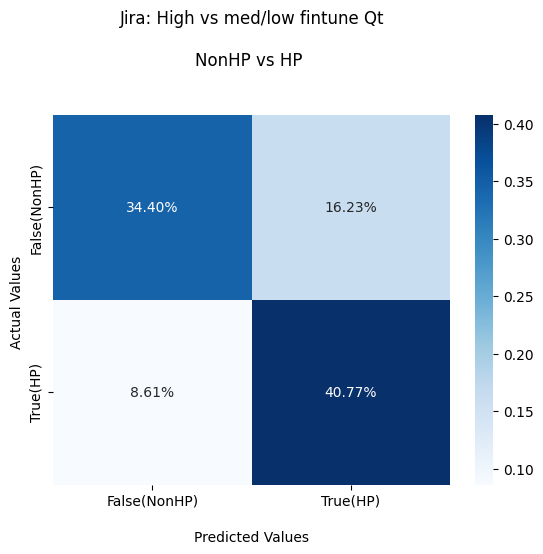

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title(f'Jira: High vs med/low fintune {project_name}\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1376
           1       0.72      0.83      0.77      1342

    accuracy                           0.75      2718
   macro avg       0.76      0.75      0.75      2718
weighted avg       0.76      0.75      0.75      2718



In [64]:
test_df[["text","label","pred"]].to_csv(f"{file_name}_70_Test_inference.csv")

In [65]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.5101096975960038


In [66]:
tracker.stop()

0.024226538002904034